In [24]:
# Import modules
import numpy as np
import astropy.units as u
import scipy.optimize as so
import scipy.stats as stats

from astropy.constants import G
from scipy.integrate import simps

# Import plotting modules
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

# Import personal modules
from ReadFile import Read
from CenterOfMass import CenterOfMass

In [25]:
# Gravitational Constant
# converting G to units of kpc*km^2/s^2/Msun
G = G.to(u.kpc*u.km**2/u.s**2/u.Msun) # 4.498768e-6*u.kpc**3/u.Gyr**2/u.Msun

In [71]:
class MassProfile:
    # Class to define the Mass and Rotation Curve of a Galaxy
    
    def __init__(self, galaxy, snap):
    # Initialize the instance of this Class with the following properties:
    # galaxy :  string, e.g. "MW"
    #  snap :  integer, e.g  1
    
        # Determine Filename
        # add a string of the filenumber to the value "000"
        ilbl = '000' + str(snap)
        # remove all but the last 3 digits
        ilbl = ilbl[-3:]
        # create filenames
        self.filename='%s_'%(galaxy) + ilbl + '.txt'
        
        # read in the file                                                                                             
        self.time, self.total, self.data = Read(self.filename)

        # store the mass, positions, velocities of all particles                                
        self.m = self.data['m']#*u.Msun
        self.x = self.data['x']*u.kpc
        self.y = self.data['y']*u.kpc
        self.z = self.data['z']*u.kpc
    
        # store galaxy name
        self.gname = galaxy
    
    
    
    def MassEnclosed(self, ptype, R):
    # Function that determines the MassEnclosed of particles of a given type
    # input: ptype  Particle type,  1=Halo, 2=Disk, 3=Bulge
    #        R   An Array of Radii within which to compute the mass enclosed. 
    # return: an array with the Mass enclosed (units of Msun)
        
        # Determine the COM position using Disk Particles
        # Disk Particles afford the best centroiding.
        # Create a COM object
        COM = CenterOfMass(self.filename,2)
        # Store the COM position of the galaxy
        # Set Delta = whatever you determined to be a good value in Homework 4.
        GalCOMP = COM.COM_P(0.1)
            
        # create an array to store indexes of particles of desired Ptype                                                
        index = np.where(self.data['type'] == ptype)

        # Store positions of particles of given ptype from the COMP. 
        xG = self.x[index] - GalCOMP[0]
        yG = self.y[index] - GalCOMP[1]
        zG = self.z[index] - GalCOMP[2]
            
        # Compute the mag. of the 3D radius
        rG = np.sqrt(xG**2 + yG**2 + zG**2)
            
        # store mass of particles of a given ptype
        mG = self.m[index]
            
        # Array to store enclosed mass as a function of the input radius array
        Menc = np.zeros(np.size(R))
    
        # set up a while loop that continues until the end of the input radius array
        for i in range(np.size(R)):
            # Only want particles within the given radius
            indexR = np.where(rG < R[i]*u.kpc)
            Menc[i] = np.sum(mG[indexR])*1e10
            Menc[0] = 100000
        
        # return the array of enclosed mass with appropriate units
        return Menc
        
    
    def MassEnclosedTotal(self, R):
    # Determine the total mass of each galaxy point
        # Input:   R   Radius 
        # Returns: Mass in units Msun. 
            
        # Sum up all the mass of each component.
        Menc = self.MassEnclosed(1,R) + self.MassEnclosed(2,R) + self.MassEnclosed(3,R)
    
        # Recall that M33 only has 2 components!  No bulge
        if (self.gname == 'M33'):
            Menc = self.MassEnclosed(1,R) + self.MassEnclosed(2,R)  
          
        return Menc
    
        
        
    def HernquistMass(self, R, scale, Mhalo):
    # Determine the mass enclosed using Hernquist 1990 Mass profile 
    # Input:   R   Radius  
    #         scale   Scale Length  
    #         Mhalo  Total Halo Mass (Msun)
    # Returns: Mass in units Msun. 
    
        # Hernquist 1990 Mass profile
        return Mhalo*R**2/(R+scale)**2
       
    
    
    # Research Assignment Additions--------------------------------------------------------------------

    def NFWMass(self, r, a, rho0):
        # Input:
            # r - the distance from the cetner of the galaxy (kpc) (must be array)
            # a - the scale radius (kpc)
            # mHalo - the total halo mass (10^12 Msun)
        # Output:
            # mNFW - the total dark matter mass enclosed within r (Msun)
        
        Rlen = len(r)
        mNFW = np.zeros(Rlen)
        rhoNFW = np.zeros(Rlen)
        dr = 0.00001
        
        for i in range(0, Rlen):
            rhoNFW[i] = rho0/((r[i]/a)*(1+(r[i]/a))**2)
            rlim = np.arange(0, r[i], r[i]*dr)
            rholim = np.arange(0, rhoNFW[i], rhoNFW[i]*dr)
            rlen = len(rlim)
            rholen = len(rholim)
            if(rlen != rholen):
                print("HELP!")
            mNFW[i] = simps(rholim, rlim)
        
        return mNFW
    
class DensityProfile:
    # Class to define the Density of a Galaxy
    
    def __init__(self, galaxy, snap):
    # Initialize the instance of this Class with the following properties:
    # galaxy :  string, e.g. "MW"
    #  snap :  integer, e.g  1
    
        # Determine Filename
        # add a string of the filenumber to the value "000"
        ilbl = '000' + str(snap)
        # remove all but the last 3 digits
        ilbl = ilbl[-3:]
        # create filenames
        self.filename='%s_'%(galaxy) + ilbl + '.txt'
        
        # read in the file                                                                                             
        self.time, self.total, self.data = Read(self.filename)

        # store the mass, positions, velocities of all particles                                
        self.m = self.data['m']#*u.Msun
        self.x = self.data['x']*u.kpc
        self.y = self.data['y']*u.kpc
        self.z = self.data['z']*u.kpc
    
        # store galaxy name
        self.gname = galaxy
        
    def NFWDen(self, r, a, rho0):
        # Input:
            # r - the distance from the cetner of the galaxy (kpc)
            # a - the scale radius (kpc)
            # rho0 - a parameter dependent on the galaxy's density
        # Output:
            # rhoNFW - the total dark matter mass enclosed within r (Msun/kpc^3)
        
        rhoNFW = rho0/((r/a)*(1+(r/a))**2)
        
        return rhoNFW

    
    def HernquistDen(self, R, scale, Mhalo):
        # Determine the mass enclosed using Hernquist 1990 Mass profile 
        # Input:   R   Radius  
        #         scale   Scale Length  
        #         Mhalo  Total Halo Mass (Msun)
        # Returns: Density in units Msun/kpc^3
        
        Rlen = len(R)
        mHernquist = Mhalo*R**2/(R+scale)**2
        V = np.zeros(Rlen)
        rhoHernquist = np.zeros(Rlen+1)
        
        for i in range(0, Rlen-1):
            V[i+1] = 4/3 * np.pi * (R[i+1]**3 - R[i]**3)
            rhoHernquist[i+1] = mHernquist[i+1]/V[i+1]
            
        return rhoHernquist[1:]
    
    
    def DenEnclosed(self, ptype, R):
    # Function that determines the MassEnclosed of particles of a given type
    # input: ptype  Particle type,  1=Halo, 2=Disk, 3=Bulge
    #        R   An Array of Radii within which to compute the mass enclosed. 
    # return: an array with the Mass enclosed (units of Msun)
        
        # Determine the COM position using Disk Particles
        # Disk Particles afford the best centroiding.
        # Create a COM object
        COM = CenterOfMass(self.filename,2)
        # Store the COM position of the galaxy
        # Set Delta = whatever you determined to be a good value in Homework 4.
        GalCOMP = COM.COM_P(0.1)
            
        # create an array to store indexes of particles of desired Ptype                                                
        index = np.where(self.data['type'] == ptype)

        # Store positions of particles of given ptype from the COMP. 
        xG = self.x[index] - GalCOMP[0]
        yG = self.y[index] - GalCOMP[1]
        zG = self.z[index] - GalCOMP[2]
            
        # Compute the mag. of the 3D radius
        rG = np.sqrt(xG**2 + yG**2 + zG**2)
            
        # store mass of particles of a given ptype
        mG = self.m[index]
            
        # Array to store enclosed mass as a function of the input radius array
        Menc = np.zeros(np.size(R)+1)
        V = np.zeros(np.size(R)+1)
        rhoEnc = np.zeros(np.size(R)+1)
    
        # set up a while loop that continues until the end of the input radius array
        for i in range(np.size(R)-1):
            # Only want particles within the given radius
            indexR = np.where(rG < R[i]*u.kpc)
            Menc[i+1] = np.sum(mG[indexR])*1e10
            V[i+1] = 4/3 * np.pi * (R[i+1]**3 - R[i]**3)
            rhoEnc[i+1] = Menc[i+1]/V[i+1]
        rhoEnc[1] = 10000
        
        # return the array of enclosed mass with appropriate units
        return rhoEnc[1:]

In [72]:
MW_I = DensityProfile("MW", 0) # Initialize the MassProfile class for MW at first Snapshot
MW_M = DensityProfile("MW", 400) # Initialize the MassProfile class for MW at middle Snapshot
MW_F = DensityProfile("MW", 801) # Initialize the MassProfile class for MW at last Snapshot

M31_I = DensityProfile("M31", 0) # Initialize the MassProfile class for M31 at first Snapshot
M31_M = DensityProfile("M31", 400) # Initialize the MassProfile class for M31 at middle Snapshot
M31_F = DensityProfile("M31", 801) # Initialize the MassProfile class for M31 at last Snapshot

Renc = np.arange(0.1,5000.1,1)

In [76]:
# for i in range(len(Renc)):
#     if(MW_I.DenEnclosed(1, Renc)[i] == 0 or \
#        MW_I.HernquistDen(Renc,62,1.921e12)[i] == 0 or \
#        MW_I.NFWDen(Renc,61,1.975e12)[i] == 0):
#         print(i)
#         print(MW_I.DenEnclosed(1, Renc)[i])
#         print(MW_I.HernquistDen(Renc,62,1.921e12)[i])
#         print(MW_I.NFWDen(Renc,61,1.975e12)[i])

for i in range(len(Renc)):
    if(MW_I.DenEnclosed(1, Renc)[i] == 0):
        print(i)
        print(MW_I.DenEnclosed(1, Renc)[i])

KeyboardInterrupt: 

In [64]:
# A function that calcualted the chi-squared values of an array compared to the expected values
# There is a scipy.stats.chisquare function, but errors were encountered when used
def χ2(x, m):
    # Inputs:
        # x - the measured values (array)
        # m - the expected values (array)
    χ2 = 0
    for i in range(len(x)):
        χ2 += ((x[i] - m[i])**2)/m[i]
    return χ2

In [74]:
# Measure discrepencies between data and density profiles

# M31 Hernquist Chi Squared
χH_M31_I = χ2(M31_I.HernquistDen(Renc,62,1.921e12), M31_I.DenEnclosed(1,Renc))
χH_M31_M = χ2(M31_M.HernquistDen(Renc,62,1.921e12), M31_M.DenEnclosed(1,Renc))
χH_M31_F = χ2(M31_F.HernquistDen(Renc,62,1.921e12), M31_F.DenEnclosed(1,Renc))

# M31 NFW Chi Squared
χNFW_M31_I = χ2(M31_I.NFWDen(Renc,62,1.921e12), M31_I.DenEnclosed(1,Renc))
χNFW_M31_M = χ2(M31_M.NFWDen(Renc,62,1.921e12), M31_M.DenEnclosed(1,Renc))
χNFW_M31_F = χ2(M31_F.NFWDen(Renc,62,1.921e12), M31_F.DenEnclosed(1,Renc))

# MW Hernquist Chi Squared
χH_MW_I = χ2(MW_I.HernquistDen(Renc,61,1.975e12), MW_I.DenEnclosed(1,Renc))
χH_MW_M = χ2(MW_M.HernquistDen(Renc,61,1.975e12), MW_M.DenEnclosed(1,Renc))
χH_MW_F = χ2(MW_F.HernquistDen(Renc,61,1.975e12), MW_F.DenEnclosed(1,Renc))

# MW NFW Chi Squared
χNFW_MW_I = χ2(MW_I.NFWDen(Renc,61,1.975e12), MW_I.DenEnclosed(1,Renc))
χNFW_MW_M = χ2(MW_M.NFWDen(Renc,61,1.975e12), MW_M.DenEnclosed(1,Renc))
χNFW_MW_F = χ2(MW_F.NFWDen(Renc,61,1.975e12), MW_F.DenEnclosed(1,Renc))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  


In [46]:
def Minimizeχ(Renc):
    # A function that minimizes the χ-squared statistic of a profile by choosing the optimal a and b constants
    # Inputs:
        # Renc - the radius enclosing the mass
    # Outputs:
        # a - the optimized scale radius
        # b - the optimized density/mass scalar
    
    # M31 Hernquist Chi Squared
    χH_M31_I = χ2(M31_I.HernquistDen(Renc,62,1.921e12), M31_I.DenEnclosed(1,Renc))
    χH_M31_M = χ2(M31_M.HernquistDen(Renc,62,1.921e12), M31_M.DenEnclosed(1,Renc))
    χH_M31_F = χ2(M31_F.HernquistDen(Renc,62,1.921e12), M31_F.DenEnclosed(1,Renc))
    aH_M31_I = 0
    aH_M31_M = 0
    aH_M31_F = 0
    bH_M31_I = 0
    bH_M31_M = 0
    bH_M31_F = 0
    
    # MW Hernquist Chi Squared
    χH_MW_I = χ2(MW_I.HernquistDen(Renc,61,1.975e12), MW_I.DenEnclosed(1,Renc))
    χH_MW_M = χ2(MW_M.HernquistDen(Renc,61,1.975e12), MW_M.DenEnclosed(1,Renc))
    χH_MW_F = χ2(MW_F.HernquistDen(Renc,61,1.975e12), MW_F.DenEnclosed(1,Renc))
    aH_MW_I = 0
    aH_MW_M = 0
    aH_MW_F = 0
    bH_MW_I = 0
    bH_MW_M = 0
    bH_MW_F = 0
    
    for a in range(60, 65, 1):
        for b in range(15, 20, 1):
            b = b*1e11
            χ_M31_I = χ2(M31_I.HernquistDen(Renc, a, b), M31_I.DenEnclosed(1,Renc))
            if(χ_M31_I <= χH_M31_I):
                aH_M31_I = a
                bH_M31_I = b
            χ_M31_M = χ2(M31_M.HernquistDen(Renc, a, b), M31_M.DenEnclosed(1,Renc))
            if(χ_M31_M <= χH_M31_M):
                aH_M31_M = a
                bH_M31_M = b
            χ_M31_F = χ2(M31_F.HernquistDen(Renc, a, b), M31_F.DenEnclosed(1,Renc))
            if(χ_M31_F <= χH_M31_F):
                aH_M31_F = a
                bH_M31_F = b
                
            χ_MW_I = χ2(MW_I.HernquistDen(Renc, a, b), MW_I.DenEnclosed(1,Renc))
            if(χ_MW_I <= χH_MW_I):
                aH_MW_I = a
                bH_MW_I = b
            χ_MW_M = χ2(MW_M.HernquistDen(Renc, a, b), MW_M.DenEnclosed(1,Renc))
            if(χ_MW_M <= χH_MW_M):
                aH_MW_M = a
                bH_MW_M = b
            χ_MW_F = χ2(MW_F.HernquistDen(Renc, a, b), MW_F.DenEnclosed(1,Renc))
            if(χ_MW_F <= χH_MW_F):
                aH_MW_F = a
                bH_MW_F = b

    # M31 NFW Chi Squared
    χNFW_M31_I = χ2(M31_I.NFWDen(Renc,62,1.921e12), M31_I.DenEnclosed(1,Renc))
    χNFW_M31_M = χ2(M31_M.NFWDen(Renc,62,1.921e12), M31_M.DenEnclosed(1,Renc))
    χNFW_M31_F = χ2(M31_F.NFWDen(Renc,62,1.921e12), M31_F.DenEnclosed(1,Renc))
    aNFW_M31_I = 0
    aNFW_M31_M = 0
    aNFW_M31_F = 0
    bNFW_M31_I = 0
    bNFW_M31_M = 0
    bNFW_M31_F = 0
    
    # MW NFW Chi Squared
    χNFW_MW_I = χ2(MW_I.NFWDen(Renc,61,1.975e12), MW_I.DenEnclosed(1,Renc))
    χNFW_MW_M = χ2(MW_M.NFWDen(Renc,61,1.975e12), MW_M.DenEnclosed(1,Renc))
    χNFW_MW_F = χ2(MW_F.NFWDen(Renc,61,1.975e12), MW_F.DenEnclosed(1,Renc))
    aNFW_MW_I = 0
    aNFW_MW_M = 0
    aNFW_MW_F = 0
    bNFW_MW_I = 0
    bNFW_MW_M = 0
    bNFW_MW_F = 0
    
    for a in range(2400, 2405, 1):
        for b in range(1, 6, 1):
            b = b*1e5
            χ_M31_I = χ2(M31_I.NFWDen(Renc, a, b), M31_I.DenEnclosed(1,Renc))
            if(χ_M31_I <= χH_M31_I):
                aH_M31_I = a
                bH_M31_I = b
            χ_M31_M = χ2(M31_M.NFWDen(Renc, a, b), M31_M.DenEnclosed(1,Renc))
            if(χ_M31_M <= χH_M31_M):
                aH_M31_M = a
                bH_M31_M = b
            χ_M31_F = χ2(M31_F.NFWDen(Renc, a, b), M31_F.DenEnclosed(1,Renc))
            if(χ_M31_F <= χH_M31_F):
                aH_M31_F = a
                bH_M31_F = b
                
            χ_MW_I = χ2(MW_I.NFWDen(Renc, a, b), MW_I.DenEnclosed(1,Renc))
            if(χ_MW_I <= χH_MW_I):
                aH_MW_I = a
                bH_MW_I = b
            χ_MW_M = χ2(MW_M.NFWDen(Renc, a, b), MW_M.DenEnclosed(1,Renc))
            if(χ_MW_M <= χH_MW_M):
                aH_MW_M = a
                bH_MW_M = b
            χ_MW_F = χ2(MW_F.NFWDen(Renc, a, b), MW_F.DenEnclosed(1,Renc))
            if(χ_MW_F <= χH_MW_F):
                aH_MW_F = a
                bH_MW_F = b
                
    print("aH_M31_I:" + aH_M31_I + "\n bH_M31_I:" + bH_M31_I)
    print("aH_M31_M:" + aH_M31_M + "\n bH_M31_M:" + bH_M31_M)
    print("aH_M31_F:" + aH_M31_F + "\n bH_M31_F:" + bH_M31_F)
    print("aH_MW_I:" + aH_MW_I + "\n bH_MW_I:" + bH_MW_I)
    print("aH_MW_M:" + aH_MW_M + "\n bH_MW_M:" + bH_MW_M)
    print("aH_MW_F:" + aH_MW_F + "\n bH_MW_F:" + bH_MW_F)
    print("aNFW_M31_I:" + aNFW_M31_I + "\n bNFW_M31_I:" + bNFW_M31_I)
    print("aNFW_M31_M:" + aNFW_M31_M + "\n bNFW_M31_I:" + bNFW_M31_I)
    print("aNFW_M31_F:" + aNFW_M31_F + "\n bNFW_M31_I:" + bNFW_M31_I)
    print("aNFW_MW_I:" + aNFW_MW_I + "\n bNFW_MW_I:" + bNFW_MW_I)
    print("aNFW_MW_M:" + aNFW_MW_M + "\n bNFW_MW_I:" + bNFW_MW_I)
    print("aNFW_MW_F:" + aNFW_MW_F + "\n bNFW_MW_I:" + bNFW_MW_I)
    
    return aH_M31_I, bH_M31_I, aH_M31_M, bH_M31_M, aH_M31_F, bH_M31_F, \
            aH_MW_I, bH_MW_I, aH_MW_M, bH_MW_M, aH_MW_F, bH_MW_F, \
            aNFW_M31_I, bNFW_M31_I, aNFW_M31_M, bNFW_M31_M, aNFW_M31_F, bNFW_M31_F, \
            aNFW_MW_I, bNFW_MW_I, aNFW_MW_M, bNFW_MW_M, aNFW_MW_F, bNFW_MW_F

In [47]:
Minimizeχ(Renc)

KeyboardInterrupt: 

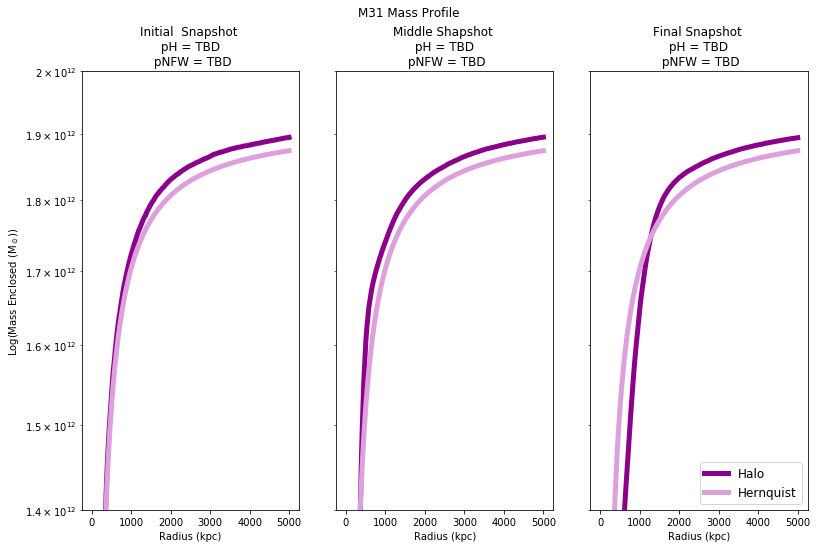

In [104]:
fig, axs = plt.subplots(1, 3, figsize=(12,8))
fig.suptitle('M31 Mass Profile') # Add title

# Hernquist and NFW Profiles at Snap 0
axs[0].semilogy(Renc,M31_I.MassEnclosed(1,Renc), color='darkmagenta', linewidth=5, label='Halo')
axs[0].semilogy(Renc,M31_I.HernquistMass(Renc,62,1.921e12), color='plum',linewidth=5, label='Hernquist')
#axs[0].semilogy(Renc,M31_I.NFWMass(Renc,2400,1.1e5), color='crimson',linewidth=5, label='NFW, a=62 kpc')
axs[0].set_title('Initial  Snapshot \n pH = TBD \n pNFW = TBD')
#axs[0].set_title('Initial  Snapshot \n pH = ' + str(pH_M31_I) + '\n pNFW = ' + str(pNFW_M31_I))

# Hernquist and NFW Profiles at Snap 400
axs[1].semilogy(Renc,M31_M.MassEnclosed(1,Renc), color='darkmagenta', linewidth=5, label='Halo')
axs[1].semilogy(Renc,M31_M.HernquistMass(Renc,62,1.921e12), color='plum',linewidth=5, label='Hernquist')
#axs[1].semilogy(Renc,M31_M.NFWMass(Renc,2400,1.1e5), color='crimson',linewidth=5, label='NFW, a=62 kpc')
axs[1].set_title('Middle Shapshot \n pH = TBD \n pNFW = TBD')
#axs[1].set_title('Middle Shapshot \n pH = ' + str(pH_M31_M) + '\n pNFW = ' + str(pNFW_M31_M))

# Hernquist and NFW Profiles at Snap 801
axs[2].semilogy(Renc,M31_F.MassEnclosed(1,Renc), color='darkmagenta', linewidth=5, label='Halo')
axs[2].semilogy(Renc,M31_F.HernquistMass(Renc,62,1.921e12), color='plum',linewidth=5, label='Hernquist')
#axs[2].semilogy(Renc,M31_F.NFWMass(Renc,2400,1.1e5), color='crimson',linewidth=5, label='NFW, a=62 kpc')
axs[2].set_title('Final Snapshot \n pH = TBD \n pNFW = TBD')
#axs[2].set_title('Final Snapshot \n pH = ' + str(pH_M31_F) + '\n pNFW = ' + str(pNFW_M31_F))

axs[0].set_ylim([1.4e12, 2e12])
axs[1].set_ylim([1.4e12, 2e12])
axs[2].set_ylim([1.4e12, 2e12])

# Add axis labels
for ax in axs.flat:
    ax.set(xlabel='Radius (kpc)', ylabel=r'Log(Mass Enclosed (M$_\odot$))')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
fig.tight_layout(pad=3.0)

# Add a legend
legend = plt.legend(loc='lower right',fontsize='large')

# Save Figure
fig.savefig('M31_MassProfile.png')

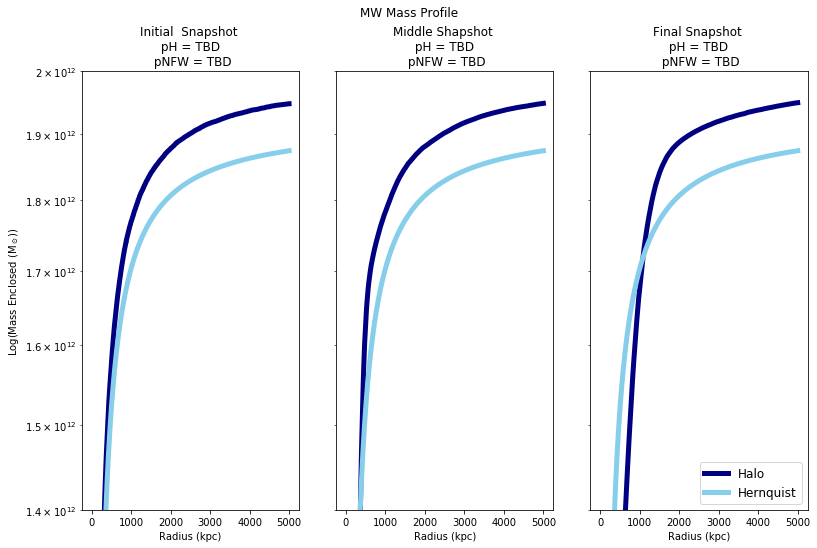

In [106]:
fig, axs = plt.subplots(1, 3, figsize=(12,8))
fig.suptitle('MW Mass Profile') # Add title

# Hernquist and NFW Profiles at Snap 0
axs[0].semilogy(Renc,MW_I.MassEnclosed(1,Renc), color='navy', linewidth=5, label='Halo')
axs[0].semilogy(Renc,MW_I.HernquistMass(Renc,62,1.921e12), color='skyblue',linewidth=5, label='Hernquist')
#axs[0].semilogy(Renc,MW_I.NFWMass(Renc,2400,1.1e5), color='dodgerblue',linewidth=5, label='NFW, a=62 kpc')
axs[0].set_title('Initial  Snapshot \n pH = TBD \n pNFW = TBD')
#axs[0].set_title('Initial  Snapshot \n pH = ' + str(pH_MW_I) + '\n pNFW = ' + str(pNFW_MW_I))

# Hernquist and NFW Profiles at Snap 400
axs[1].semilogy(Renc,MW_M.MassEnclosed(1,Renc), color='navy', linewidth=5, label='Halo')
axs[1].semilogy(Renc,MW_M.HernquistMass(Renc,62,1.921e12), color='skyblue',linewidth=5, label='Hernquist')
#axs[1].semilogy(Renc,MW_M.NFWMass(Renc,2400,1.1e12), color='dodgerblue',linewidth=5, label='NFW, a=62 kpc')
axs[1].set_title('Middle Shapshot \n pH = TBD \n pNFW = TBD')
#axs[1].set_title('Middle Shapshot \n pH = ' + str(pH_MW_M) + '\n pNFW = ' + str(pNFW_MW_M))

# Hernquist and NFW Profiles at Snap 801
axs[2].semilogy(Renc,MW_F.MassEnclosed(1,Renc), color='navy', linewidth=5, label='Halo')
axs[2].semilogy(Renc,MW_F.HernquistMass(Renc,62,1.921e12), color='skyblue',linewidth=5, label='Hernquist')
#axs[2].semilogy(Renc,MW_F.NFWMass(Renc,2400,1.1e5), color='dodgerblue',linewidth=5, label='NFW, a=62 kpc')
axs[2].set_title('Final Snapshot \n pH = TBD \n pNFW = TBD')
#axs[2].set_title('Final Snapshot \n pH = ' + str(pH_MW_F) + '\n pNFW = ' + str(pNFW_MW_F))

axs[0].set_ylim([1.4e12, 2e12])
axs[1].set_ylim([1.4e12, 2e12])
axs[2].set_ylim([1.4e12, 2e12])

# Add axis labels
for ax in axs.flat:
    ax.set(xlabel='Radius (kpc)', ylabel=r'Log(Mass Enclosed (M$_\odot$))')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
fig.tight_layout(pad=3.0)

# Add a legend
legend = plt.legend(loc='lower right',fontsize='large')

# Save Figure
fig.savefig('MW_MassProfile.png')

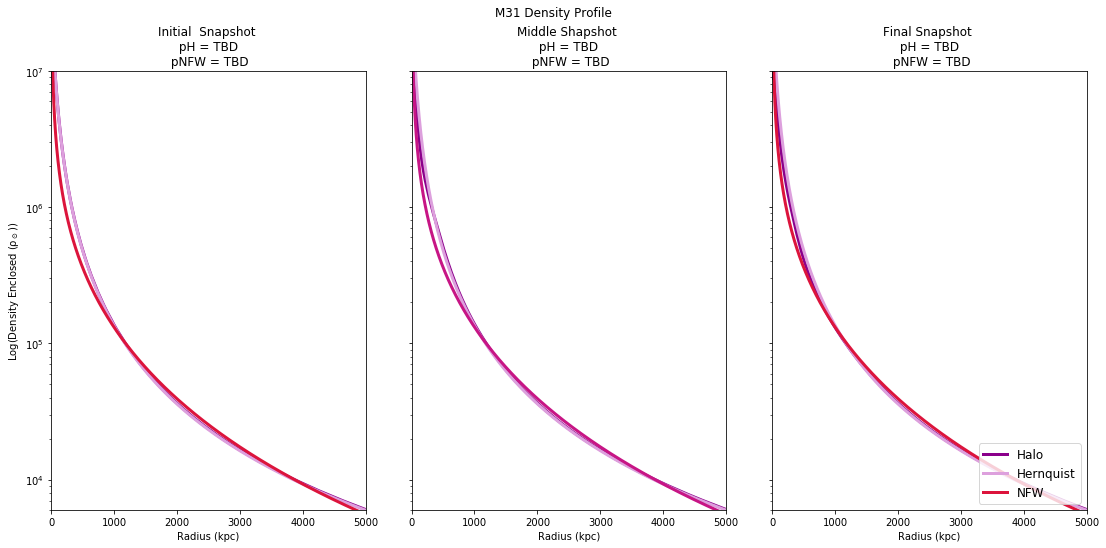

In [99]:
fig, axs = plt.subplots(1, 3, figsize=(16,8))
fig.suptitle('M31 Density Profile') # Add title

# Hernquist and NFW Profiles at Snap 0
axs[0].semilogy(Renc[1:],M31_I.DenEnclosed(1,Renc)[1:], color='darkmagenta', linewidth=3, label='Halo')
axs[0].semilogy(Renc,M31_I.HernquistDen(Renc,62,1.921e12), color='plum',linewidth=3, label='Hernquist')
axs[0].semilogy(Renc,M31_I.NFWDen(Renc,2400,1.1e5), color='crimson',linewidth=3, label='NFW')
axs[0].set_title('Initial  Snapshot \n pH = TBD \n pNFW = TBD')
#axs[0].set_title('Initial  Snapshot \n pH = ' + str(pH_M31_I) + '\n pNFW = ' + str(pNFW_M31_I))

# Hernquist and NFW Profiles at Snap 400
axs[1].semilogy(Renc[1:],M31_M.DenEnclosed(1,Renc)[1:], color='darkmagenta', linewidth=3, label='Halo')
axs[1].semilogy(Renc,M31_M.HernquistDen(Renc,62,1.921e12), color='plum',linewidth=3, label='Hernquist')
axs[1].semilogy(Renc,M31_M.NFWDen(Renc,2400,1.1e5), color='mediumvioletred',linewidth=3, label='NFW')
axs[1].set_title('Middle Shapshot \n pH = TBD \n pNFW = TBD')
#axs[1].set_title('Middle Shapshot \n pH = ' + str(pH_M31_M) + '\n pNFW = ' + str(pNFW_M31_M))

# Hernquist and NFW Profiles at Snap 801
axs[2].semilogy(Renc[1:],M31_F.DenEnclosed(1,Renc)[1:], color='darkmagenta', linewidth=3, label='Halo')
axs[2].semilogy(Renc,M31_F.HernquistDen(Renc,62,1.921e12), color='plum',linewidth=3, label='Hernquist')
axs[2].semilogy(Renc,M31_F.NFWDen(Renc,2400,1.1e5), color='crimson',linewidth=3, label='NFW')
axs[2].set_title('Final Snapshot \n pH = TBD \n pNFW = TBD')
#axs[2].set_title('Final Snapshot \n pH = ' + str(pH_M31_F) + '\n pNFW = ' + str(pNFW_M31_F))

axs[0].set_ylim([6e3, 1e7])
axs[1].set_ylim([6e3, 1e7])
axs[2].set_ylim([6e3, 1e7])

axs[0].set_xlim([0, 5000])
axs[1].set_xlim([0, 5000])
axs[2].set_xlim([0, 5000])

# Add axis labels
for ax in axs.flat:
    ax.set(xlabel='Radius (kpc)', ylabel=r'Log(Density Enclosed (ρ$_\odot$))')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
fig.tight_layout(pad=3.0)

# Add a legend
legend = plt.legend(loc='lower right',fontsize='large')

# Save Figure
#fig.savefig('M31_DensityProfile.png')

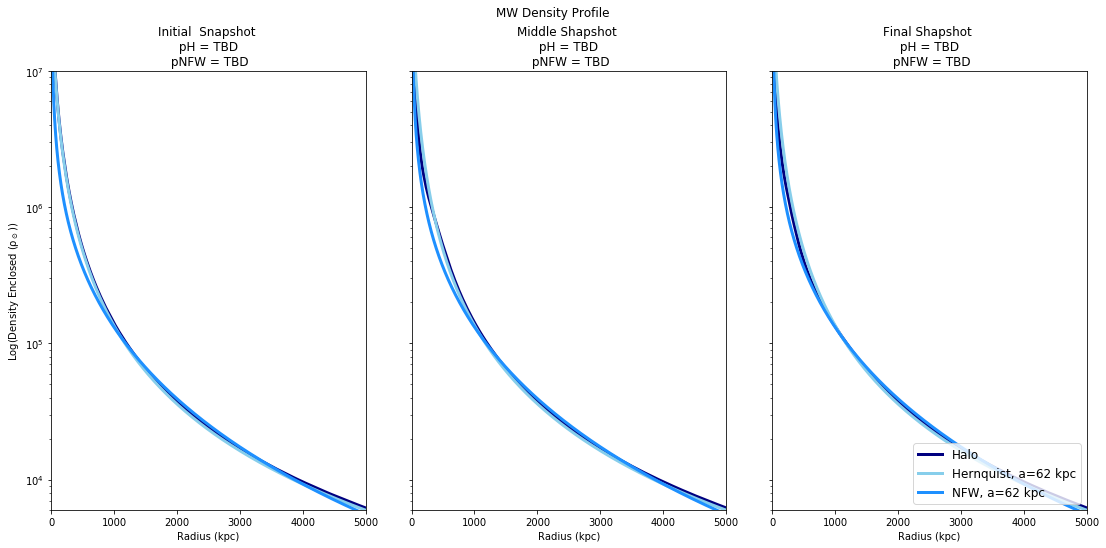

In [101]:
fig, axs = plt.subplots(1, 3, figsize=(16,8))
fig.suptitle('MW Density Profile') # Add title

# Hernquist and NFW Profiles at Snap 0
axs[0].semilogy(Renc[1:],MW_I.DenEnclosed(1,Renc)[1:], color='navy', linewidth=3, label='Halo')
axs[0].semilogy(Renc,MW_I.HernquistDen(Renc,62,1.921e12), color='skyblue',linewidth=3, label='Hernquist, a=62 kpc')
axs[0].semilogy(Renc,MW_I.NFWDen(Renc,2400,1.1e5), color='dodgerblue',linewidth=3, label='NFW, a=62 kpc')
axs[0].set_title('Initial  Snapshot \n pH = TBD \n pNFW = TBD')
#axs[0].set_title('Initial  Snapshot \n pH = ' + str(pH_M31_I) + '\n pNFW = ' + str(pNFW_M31_I))

# Hernquist and NFW Profiles at Snap 400
axs[1].semilogy(Renc[1:],MW_M.DenEnclosed(1,Renc)[1:], color='navy', linewidth=3, label='Halo')
axs[1].semilogy(Renc,MW_M.HernquistDen(Renc,62,1.921e12), color='skyblue',linewidth=3, label='Hernquist, a=62 kpc')
axs[1].semilogy(Renc,MW_M.NFWDen(Renc,2400,1.1e5), color='dodgerblue',linewidth=3, label='NFW, a=62 kpc')
axs[1].set_title('Middle Shapshot \n pH = TBD \n pNFW = TBD')
#axs[1].set_title('Middle Shapshot \n pH = ' + str(pH_M31_M) + '\n pNFW = ' + str(pNFW_M31_M))

# Hernquist and NFW Profiles at Snap 801
axs[2].semilogy(Renc[1:],MW_F.DenEnclosed(1,Renc)[1:], color='navy', linewidth=3, label='Halo')
axs[2].semilogy(Renc,MW_F.HernquistDen(Renc,62,1.921e12), color='skyblue',linewidth=3, label='Hernquist, a=62 kpc')
axs[2].semilogy(Renc,MW_F.NFWDen(Renc,2400,1.1e5), color='dodgerblue',linewidth=3, label='NFW, a=62 kpc')
axs[2].set_title('Final Shapshot \n pH = TBD \n pNFW = TBD')
#axs[2].set_title('Final Snapshot \n pH = ' + str(pH_M31_F) + '\n pNFW = ' + str(pNFW_M31_F))

axs[0].set_ylim([6e3, 1e7])
axs[1].set_ylim([6e3, 1e7])
axs[2].set_ylim([6e3, 1e7])

axs[0].set_xlim([0, 5000])
axs[1].set_xlim([0, 5000])
axs[2].set_xlim([0, 5000])

# Add axis labels
for ax in axs.flat:
    ax.set(xlabel='Radius (kpc)', ylabel=r'Log(Density Enclosed (ρ$_\odot$))')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
fig.tight_layout(pad=3.0)

# Add a legend
legend = plt.legend(loc='lower right',fontsize='large')

# Save Figure
fig.savefig('MW_DensityProfile.png')

In [ ]:
# Plot difference between Density Profiles of Initial and Subesquent Snapshots